In [1]:
# unsloth仅支持LoRA微调，所以这里我们不能用unsloth

In [2]:
import torch
import torchvision

print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print(torch.version.cuda)

Torch version: 2.4.0+cu121
Torchvision version: 0.19.0+cu121
12.1


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from datasets import Dataset

from transformers import AutoTokenizer, AutoModelForCausalLM

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

2024-11-24 02:05:16.812157: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 02:05:16.812190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 02:05:16.812667: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 02:05:16.816385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 02:05:17.225747: W tensorflow/compiler/tf2

## 获得模型和tokenizer

In [5]:
base_model="meta-llama/Llama-3.2-1B"
max_seq_length=5020

In [6]:
model = AutoModelForCausalLM.from_pretrained(base_model)
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
# 不加这两句话 trainer.train()可能报错
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

In [7]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

## 处理MMLU数据集，构造提示词

In [8]:
from datasets import load_dataset

mmlu = load_dataset("cais/mmlu", "all")

在lm-evaluation-harness\tests\test_prompt.py可以找到MMLU的提示词模板  
在lm-evaluation-harness\lm_eval\__main__.py 可以找到lm_eval的所有参数（比如num_fewshot可以控制ICL examples的数量）

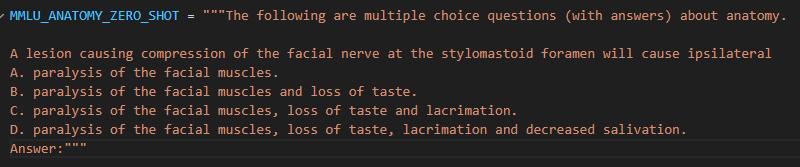

In [9]:
mmlu['auxiliary_train'][0]

{'question': "Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were",
 'subject': '',
 'choices': ['Adams only.', 'Brooks only.', 'Case only.', 'Adams and Brooks'],
 'answer': 1}

In [10]:
# 因为是zero-shot，所以不需要前面的description
# Answer和答案中间需要有一个空格
# question需要strip()去除前后可能存在的空格
# 需要用doc_to_choice把answer换成ABCD
prompt_template="""{}
A. {}
B. {}
C. {}
D. {}
Answer: {}"""

EOS_TOKEN = tokenizer.eos_token
doc_to_choice = ["A", "B", "C", "D"]

def formatting_prompt(examples):
    questions = [q.strip() for q in examples['question']]
    choices = examples['choices']
    answers = examples['answer']
    texts = []
    for question, choice, answer in zip(questions, choices, answers):
        text = prompt_template.format(question, choice[0], choice[1], choice[2], choice[3], doc_to_choice[answer]) + EOS_TOKEN # 注意最后要加上EOS
        texts.append(text)
    return { "text" : texts, }

In [11]:
training_data=mmlu['auxiliary_train'].map(formatting_prompt, batched= True)

In [12]:
print(training_data['text'][0])

Davis decided to kill Adams. He set out for Adams's house. Before he got there he saw Brooks, who resembled Adams. Thinking that Brooks was Adams, Davis shot at Brooks. The shot missed Brooks but wounded Case, who was some distance away. Davis had not seen Case. In a prosecution under a statute that proscribes any attempt to commit murder, the district attorney should indicate that the intended victim(s) was/were
A. Adams only.
B. Brooks only.
C. Case only.
D. Adams and Brooks
Answer: B<|end_of_text|>


In [13]:
# 计算所有text的长度
training_data = training_data.map(lambda x: {"text_len": len(x["text"])})
print(training_data[0]['text_len'])
print(len(training_data))

506
99842


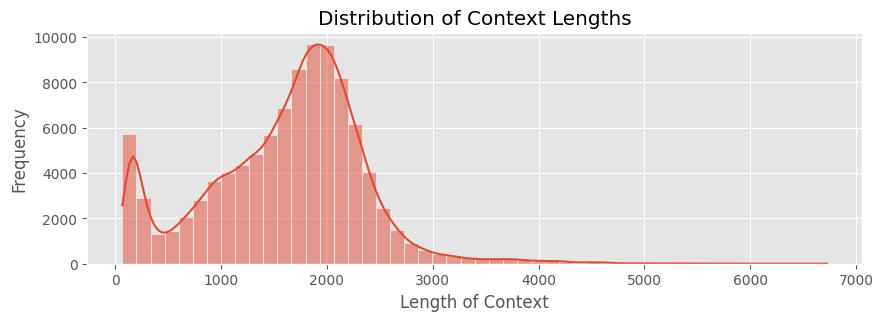

In [14]:
plt.figure(figsize=(10, 3))
sns.histplot(training_data['text_len'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

In [15]:
# 观察到绝大多数样本的长度<4000，这里我们直接删除掉长度>4000的样本即可
training_data = training_data.filter(lambda x: x["text_len"] <= 4000)
len(training_data)

99340

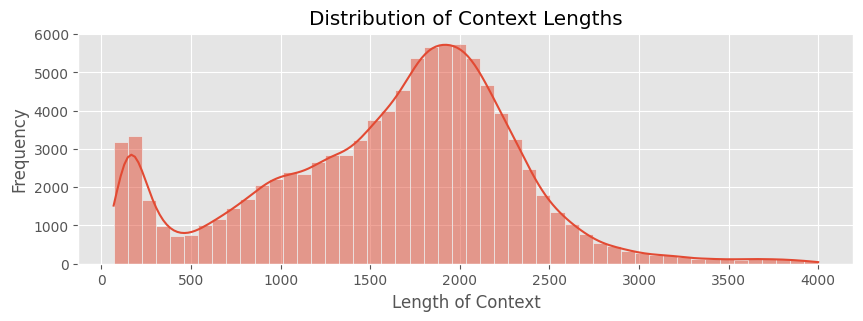

In [16]:
plt.figure(figsize=(10, 3))
sns.histplot(training_data['text_len'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

## IA3微调

In [17]:
# 参考1：https://huggingface.co/docs/peft/conceptual_guides/ia3
# 参考2：https://github.com/huggingface/peft/blob/main/src/peft/tuners/ia3/config.py
from peft import IA3Config, get_peft_model,TaskType

In [18]:
# 参考3: https://huggingface.co/docs/peft/main/package_reference/ia3
peft_config = IA3Config(
    task_type=TaskType.SEQ_CLS, target_modules=["k_proj", "v_proj", "down_proj"], feedforward_modules=["down_proj"]
)

In [19]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 147,456 || all params: 1,235,961,856 || trainable%: 0.0119


In [20]:
from trl import SFTConfig, SFTTrainer

In [21]:
training_args = SFTConfig(
    max_seq_length=max_seq_length,
    learning_rate=3e-4,
    lr_scheduler_type="linear",
    per_device_train_batch_size=3,
    gradient_accumulation_steps=16,
    num_train_epochs=3,
    fp16=True,
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    warmup_steps=10,
    output_dir="output",
    seed=0,
)

In [22]:
dataset = load_dataset("cais/mmlu", 'all')['auxiliary_train']

In [23]:
trainer=SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    dataset_num_proc=2,
    args=training_args
)

In [24]:
trainer.train()

Step,Training Loss
1,2.616900
2,2.425500
3,2.493000
4,2.471100
5,2.528600
6,2.425100
7,2.521600
8,2.493000
9,2.525700
10,2.506600


TrainOutput(global_step=6207, training_loss=2.3764677323714265, metrics={'train_runtime': 35172.9205, 'train_samples_per_second': 8.473, 'train_steps_per_second': 0.176, 'total_flos': 8.181499600858522e+17, 'train_loss': 2.3764677323714265, 'epoch': 2.9990940387751404})

In [25]:
model.save_pretrained("model/1B_finetuned_llama3.2_IA3_mmlu")
tokenizer.save_pretrained("model/1B_finetuned_llama3.2_IA3_mmlu")

('model/1B_finetuned_llama3.2_IA3_mmlu/tokenizer_config.json',
 'model/1B_finetuned_llama3.2_IA3_mmlu/special_tokens_map.json',
 'model/1B_finetuned_llama3.2_IA3_mmlu/tokenizer.json')

In [26]:
# os.environ["HF_TOKEN"] = "替换成你自己的hugging face密钥"
model.push_to_hub("1B_finetuned_llama3.2_IA3_mmlu", use_auth_token=os.getenv("HF_TOKEN"))
tokenizer.push_to_hub("1B_finetuned_llama3.2_IA3_mmlu", use_auth_token=os.getenv("HF_TOKEN"))

adapter_model.safetensors:   0%|          | 0.00/596k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/yuntaozh/1B_finetuned_llama3.2_IA3_mmlu/commit/4c5cd2dea27a018d28e370dea59d93c6675f0160', commit_message='Upload tokenizer', commit_description='', oid='4c5cd2dea27a018d28e370dea59d93c6675f0160', pr_url=None, repo_url=RepoUrl('https://huggingface.co/yuntaozh/1B_finetuned_llama3.2_IA3_mmlu', endpoint='https://huggingface.co', repo_type='model', repo_id='yuntaozh/1B_finetuned_llama3.2_IA3_mmlu'), pr_revision=None, pr_num=None)